In [144]:
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from datasets import load_dataset
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

ID_TO_LABEL = {0: 'MildDemented', 1: 'ModerateDemented', 2: 'NonDemented', 3: 'VeryMildDemented'}

In [ ]:
# Load the Falah/Alzheimer_MRI dataset
dataset = load_dataset('Falah/Alzheimer_MRI')
dataset_train = dataset['train']
dataset_test = dataset['test']

## Define the custom dataset

In this section, a custom dataset class named `AlzheimerMRIDataset` is being defined which is an inherited subclass of the PyTorch `Dataset` class. 

Here, the `__init__` method initializes the dataset class. It takes:
- `data`: The input dataset containing MRI images and their corresponding labels.
- `transform`: Any transformations to be applied to the MRI images. It's set to `None` by default.

The `__len__` method returns the total number of samples in the dataset.

The `__getitem__` method retrieves a sample from the dataset given an index `idx`. The sample includes an MRI image and its associated label. Additionally:
- The MRI image data, which is stored as bytes, is first read and converted to a PIL image format.
- If there are any transformations provided (like resizing or normalization), they are applied to the image.

---

## Define the image transformations

PyTorch provides a `transforms` module to easily define and apply common transformations to the images. Here, a series of transformations are being defined:

These transformations will:
1. Resize the image to 400x400 pixels.
2. Center crop the image to 256x256 pixels.
3. Convert the image from a PIL format to a PyTorch tensor.
4. Normalize the tensor with a mean of 0.485 and standard deviation of 0.229. 

---

## Create Dataset instances and DataLoader

With the dataset class and transformations defined, you can now create instances of your dataset for training and testing purposes.

`train_dataset` and `test_dataset` are instances of the custom `AlzheimerMRIDataset` class, containing the training and testing data respectively, with the previously defined transformations applied.

Finally, `DataLoader` is a PyTorch utility that helps with batching, shuffling, and loading data in parallel. Here, data loaders are created for both training and testing datasets with a batch size of 32. The training data is shuffled for each epoch to ensure variability in training, but the testing data remains in order to evaluate the model consistently.

In [258]:
# Define the custom dataset
class AlzheimerMRIDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_data = self.data[idx]['image']['bytes']
        label = self.data[idx]['label']
        
        # Convert byte image data to PIL image
        image = Image.open(io.BytesIO(image_data))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define the transforms you want to apply
transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.CenterCrop((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,), (0.229,))
])

train_dataset = AlzheimerMRIDataset(dataset_train, transform=transform)
test_dataset = AlzheimerMRIDataset(dataset_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Visualize a batch of training data

Let's visualize a batch of training data to see what the images look like after the transformations have been applied.

We can see that the images have been resized to 400x400 pixels, center cropped to 256x256 pixels, and normalized. Now that the data is ready, we can start building the model.
- Only the center of the image is used because the edges of the brain are not important for classification.

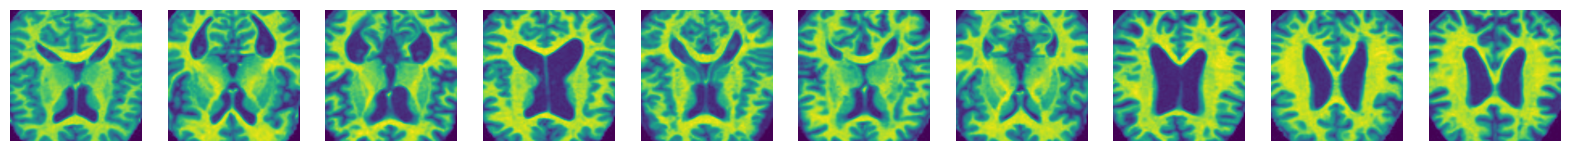

In [259]:
# Fetch the first batch from the DataLoader
images, labels = next(iter(train_loader))

# Function to display images
def imshow(img):
    img = img * 0.229 + 0.485
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Display the first 10 images
fig = plt.figure(figsize=(20, 5))
for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    imshow(images[i])

## Classification Model Breakdown
Our main class, `ClassificationModel`, is built upon PyTorch's `nn.Module`, which means it's a custom neural network module.

### Initialization (`__init__` method):
1. **Convolutional layers**: These layers help the model understand and detect spatial hierarchies in an image. Basically, it's learning patterns like edges, textures, etc.
   - `conv1`: Detects initial low-level features (like edges) from grayscale images.
   - `conv2`: Builds upon `conv1` and detects slightly more complex features.
   - `conv3`: Further refines the features by building upon `conv2`.

2. **Fully connected layers**: These are the traditional neural network layers you might be familiar with. They help in making the final decision (classification).
   - `fc1`, `fc2`, and `fc3` are the linear layers to reduce the high-dimensional data and make the final classification decision.

3. **Dropout**: A simple way to prevent our model from overfitting (memorizing the training data). The dropout layer randomly "turns off" a fraction (in this case, 50% or 0.5) of its neurons during each training step. This ensures that the model doesn't rely too heavily on any particular neuron.

### Forward Method:
This method defines the forward pass of our network (i.e., how data flows through it).

1. **Convolutional Layers Flow**:
   - Data is passed through each convolutional layer.
   - After each layer, a ReLU (Rectified Linear Unit) activation function is applied, ensuring non-linearity.
   - After activation, a pooling operation (`max_pool2d`) reduces the spatial dimensions of the data.

2. **Flattening**:
   - After the convolutional layers, the 2D data is flattened into a 1D tensor to be passed to the fully connected layers.

3. **Fully Connected Layers Flow**:
   - Data flows through the first fully connected layer (`fc1`) followed by a ReLU activation and dropout.
   - Then, it flows through the second fully connected layer (`fc2`), followed by another ReLU activation and dropout.
   - Finally, data flows through the third fully connected layer (`fc3`) which outputs the final predictions.

In [262]:
# Assume you have CUDA available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ClassificationModel(nn.Module):
    def __init__(self, num_classes):
        super(ClassificationModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # Assuming grayscale images
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Layer 1
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        # Layer 2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        # Layer 3
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

## Creating and Preparing the Neural Network

1. We define `num_classes` as 4, meaning our model will classify input data into one of four categories.

2. We then create an instance of the `ClassificationModel` and send it to the appropriate device (either CPU or GPU).

3. Next, we set up our loss function (`criterion`), which is `CrossEntropyLoss`. This function measures how well the model's predictions match the actual labels of the training data.

4. The optimizer chosen is `AdamW`, a variant of the popular `Adam` optimizer. It is responsible for updating the model's weights based on the gradients.

---

## Training and Testing the Model

1. We define the number of training iterations (`num_epochs`) as 10 and initialize lists to keep track of various metrics' history.

2. For each epoch:
    - The model is set to `train()` mode.
    - We loop over our training data (`train_loader`), send it to the correct device, and clear previous gradients with `optimizer.zero_grad()`.
    - We then make predictions using the model and compute the loss.
    - The gradients are calculated using `loss.backward()` and the optimizer updates the weights with `optimizer.step()`.
    - The epoch's loss is accumulated and later averaged.

3. After each epoch's training, we evaluate the model on the testing data:
    - The model is set to `eval()` mode, meaning we won't compute gradients here.
    - We loop over our test data (`test_loader`) and make predictions.
    - Predicted labels are extracted using `torch.max()`, and they're stored alongside the true labels.

4. We then compute performance metrics:
    - **Accuracy**: It's the percentage of correct predictions.
    - **Precision**: It measures the model's exactness. It’s the ratio of correctly predicted positive observations to the total predicted positives.
    - **Recall (Sensitivity)**: It measures the model's completeness. It’s the ratio of correctly predicted positive observations to all the actual positives.
    - **F1 Score**: It's the weighted average of Precision and Recall, giving equal importance to both.

5. At the end of each epoch, the computed metrics are printed.

In [263]:
num_classes = 4
model = ClassificationModel(num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

num_epochs = 10
train_loss_history = []
accuracy_history = []
precision_history = []
recall_history = []
f1_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    average_epoch_loss = epoch_loss / len(train_loader)
    train_loss_history.append(average_epoch_loss)

    # Testing loop
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * sum([a == b for a, b in zip(all_labels, all_predictions)]) / len(all_labels)
    accuracy_history.append(accuracy)

    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0) * 100
    precision_history.append(precision)

    recall = recall_score(all_labels, all_predictions, average='macro') * 100
    recall_history.append(recall)

    f1 = f1_score(all_labels, all_predictions, average='macro') * 100
    f1_history.append(f1)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {average_epoch_loss:.4f} | Accuracy: {accuracy:.2f}% | Precision: {precision:.2f}% | Recall: {recall:.2f}% | F1: {f1:.2f}%")


Epoch 1/10 | Loss: 1.0222 | Accuracy: 56.95% | Precision: 52.09% | Recall: 32.19% | F1: 30.14%
Epoch 2/10 | Loss: 0.8058 | Accuracy: 69.14% | Precision: 54.84% | Recall: 42.32% | F1: 43.08%
Epoch 3/10 | Loss: 0.4704 | Accuracy: 85.86% | Precision: 63.09% | Recall: 64.94% | F1: 63.39%
Epoch 4/10 | Loss: 0.2216 | Accuracy: 93.67% | Precision: 69.51% | Recall: 70.78% | F1: 70.10%
Epoch 5/10 | Loss: 0.1205 | Accuracy: 96.17% | Precision: 97.73% | Recall: 89.52% | F1: 93.05%
Epoch 6/10 | Loss: 0.0841 | Accuracy: 95.31% | Precision: 96.54% | Recall: 91.42% | F1: 93.70%
Epoch 7/10 | Loss: 0.0607 | Accuracy: 95.94% | Precision: 97.62% | Recall: 92.41% | F1: 94.82%
Epoch 8/10 | Loss: 0.0403 | Accuracy: 95.47% | Precision: 97.34% | Recall: 91.30% | F1: 94.03%
Epoch 9/10 | Loss: 0.0466 | Accuracy: 93.52% | Precision: 96.75% | Recall: 90.45% | F1: 93.26%
Epoch 10/10 | Loss: 0.0470 | Accuracy: 96.41% | Precision: 97.90% | Recall: 92.51% | F1: 94.99%


## Visualizing the Confusion Matrix

1. **Computing the Confusion Matrix**:
    - First, the `confusion_matrix` function is called, which comes from the scikit-learn library. This function compares the model's predictions (`all_predictions`) against the true labels (`all_labels`).
    - The resulting matrix (`cm`) indicates how many times each class was predicted as each class. Diagonal elements represent correct predictions, while off-diagonal elements indicate errors.

2. **Plotting the Matrix**:
    - We're using both `matplotlib` and `seaborn` (a higher-level visualization library) to make the plot more visually appealing.
    - The size of the resulting plot is set to 10x8 inches using `plt.figure(figsize=(10, 8))`.

    - `sns.heatmap()`: This function is used to visualize the confusion matrix. The parameters it uses are:
        - `cm`: The actual confusion matrix data.
        - `annot=True`: This makes sure the actual numbers are shown in each cell of the heatmap.
        - `fmt='g'`: Ensures numbers are displayed without any decimal places.
        - `cmap='Blues'`: Sets the color palette to shades of blue. The darker the shade, the higher the value.
        - `xticklabels` and `yticklabels`: They label the x and y axis ticks with actual class names provided by the `ID_TO_LABEL` dictionary.
    
    - We then label the x-axis and y-axis and give the plot a title.

    - Finally, `plt.show()` is called to display the plot.

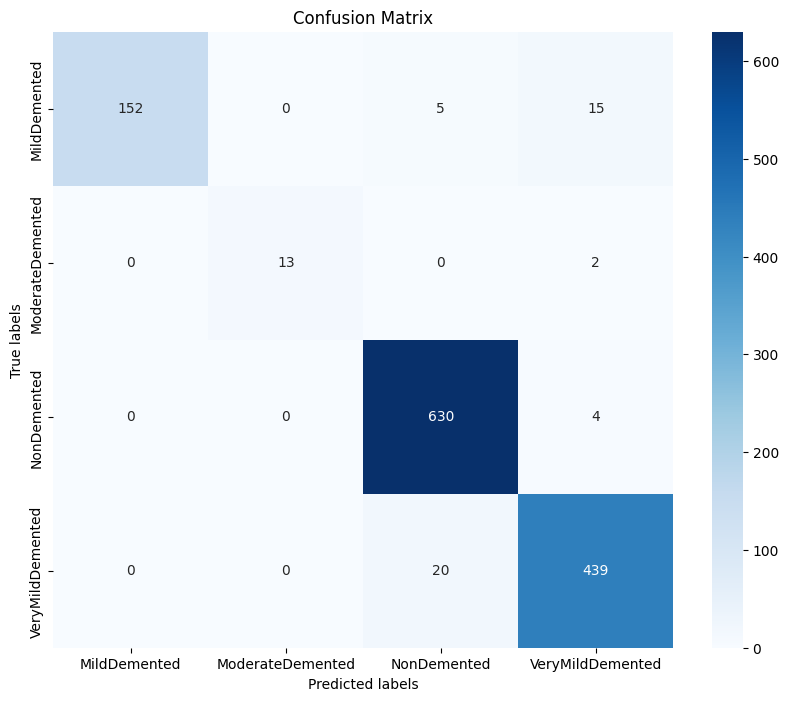

In [264]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plotting using matplotlib and seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=ID_TO_LABEL.values(), 
            yticklabels=ID_TO_LABEL.values())

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Breakdown:

1. **Compute CAM Function**:
    - `compute_cam(image, model, weights, get_intermediate_output)`:
        - The function takes an image, the model, weights from a particular layer of the model (in this case, from `fc1`), and a method to get the output of an intermediate layer.
        - `image.unsqueeze(0).to(device)` is used to add an extra batch dimension to the image and send it to the appropriate device (CPU/GPU).
        - The model then makes a prediction on this image and identifies the predicted class.
        - The Class Activation Map (`cam`) is computed using the weights of the predicted class and the intermediate outputs after the `conv3` layer. This CAM is then resized to 256x256 pixels and normalized to the range [0, 1].
        - The function returns the CAM and the predicted class.

2. **Hook Registration**:
    - The function `register_hook(model, 'conv3')` is assumed to register a hook to the `conv3` layer of the model. This hook will allow us to capture the outputs of the `conv3` layer whenever the model processes an image.

3. **Selecting Images from Test Dataset**:
    - This segment chooses 16 images from the test dataset that have labels 0, 1, 2, or 3.

4. **Visualization**:
    - A figure with dimensions 20x20 is initialized.
    - For each of the selected images:
        - Compute the CAM using the `compute_cam()` function.
        - Plot the CAM and the actual image side by side, overlaying them to highlight regions of interest. The region the model focuses on will be colored using the `jet` colormap.
        - Display predicted and actual labels as the title.

5. **Hook Removal**: 
    - After using the hook, it's important to remove it to ensure it doesn't interfere with further operations or evaluations on the model. Thus, the last line is `hook.remove()`.

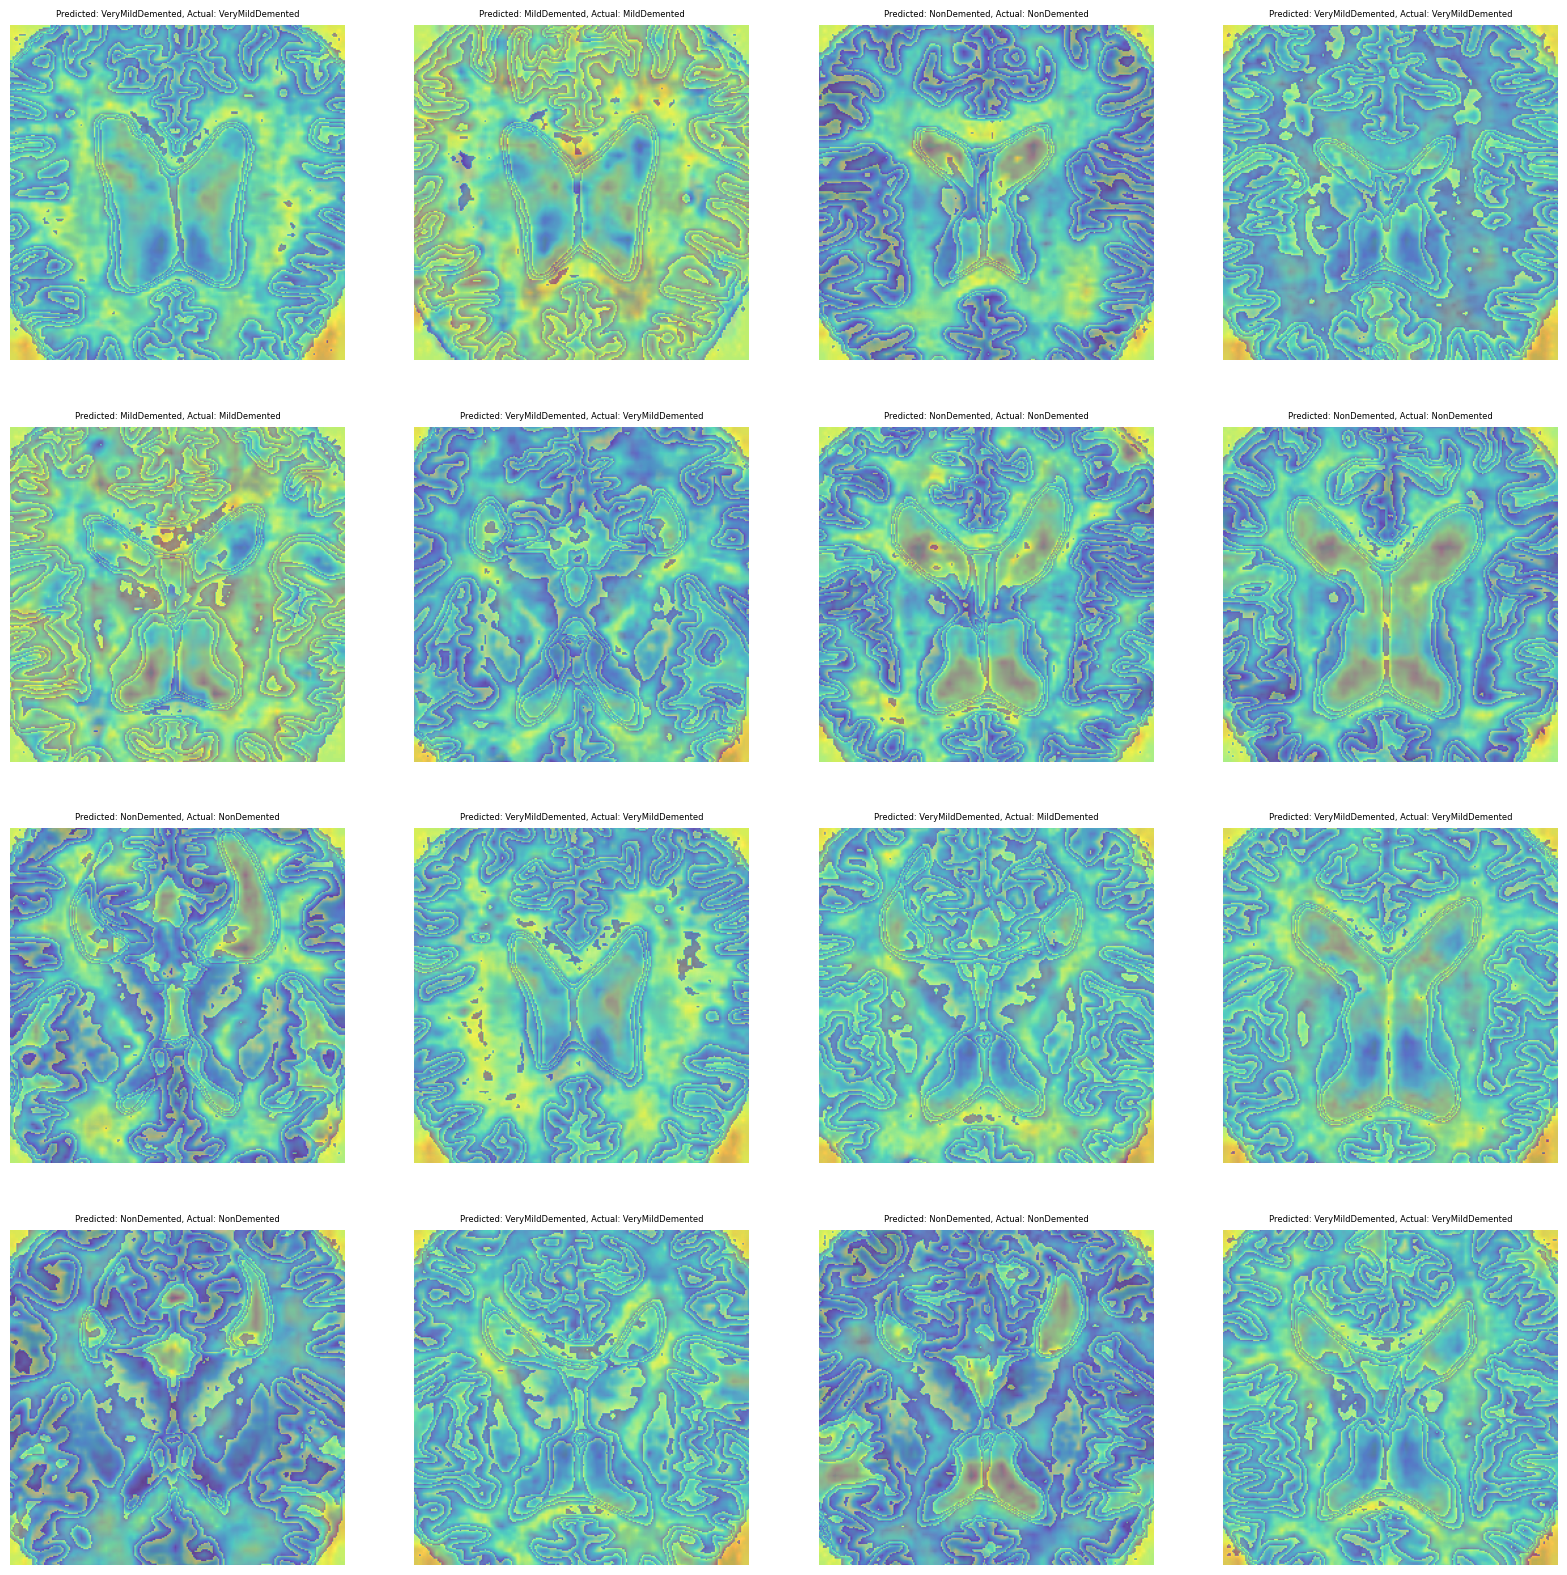

In [265]:
# Function to compute CAM for a given image and model
def compute_cam(image, model, weights, get_intermediate_output):
    image = image.unsqueeze(0).to(device)
    outputs = model(image)
    _, predicted_class = outputs.max(1)
    predicted_class = predicted_class[0].item()
    intermediate_output = get_intermediate_output()[0]

    cam = (weights[predicted_class].reshape(128, 32, 32) * F.max_pool2d(intermediate_output, 2)).sum(dim=0)
    cam = cv2.resize(cam.cpu().detach().numpy(), (256, 256))
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    return cam, predicted_class

hook, get_intermediate_output = register_hook(model, 'conv3')

# Visualize CAM for each image in the test dataset
# take 16 images from the test dataset with labels 0, 1, 2, 3
test_dataset_4 = []
for i in range(len(test_dataset)):
    image, label = test_dataset[i]
    if label in [0, 1, 2, 3]:
        test_dataset_4.append((image, label))
    if len(test_dataset_4) == 16:
        break

# Visualize CAM for each image in the test dataset
fig = plt.figure(figsize=(20, 20))
for i in range(len(test_dataset_4)):
    image, label = test_dataset_4[i]
    cam, predicted_class = compute_cam(image, model, model.fc1.weight, get_intermediate_output)
    ax = fig.add_subplot(4, 4, i+1)
    ax.set_title(f"Predicted: {ID_TO_LABEL[predicted_class]}, Actual: {ID_TO_LABEL[label]}")
    ax.title.set_fontsize(6)
    ax.imshow(cam, alpha=0.5, cmap='jet')
    ax.imshow(transforms.ToPILImage()(image.cpu()), alpha=0.5)
    ax.axis('off')

plt.show()

hook.remove()